# PAPER REPLICATION OF: AN ENSEMBLE OF SIMPLE CONVOLUTIONAL NEURAL NETWORK MODELS FOR MNIST DIGIT RECOGNITION [[1]](https://arxiv.org/abs/2008.10400)

### Made by: Rodrigo González Marcet

## Initial summary

In this paper replication we will study the performance of various CNN ensemble architectures in the MNIST dataset. In total, 6 experiments will be made, each with its own results. The first 3 experiments test the impact on performance of pooling, data transformations (rotation and translation) and batch normalization. The last 3 will be focused on creating different ensemble stategies to improve the performance of standard more common methods.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Establecer la semilla que vamos a utilizar
np.random.seed(42)

from tensorflow import keras

#import keras
!pip install np_utils
from keras.utils import to_categorical
from keras.datasets import mnist
keras.utils.set_random_seed(42)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, BatchNormalization, ReLU, Softmax
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers.legacy import Adam

from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras import backend as K

from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import mode

import random

# Needed to save the models after training
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model

import seaborn as sns
from scipy import stats

import pandas as pd

# NÚMERO DE CLASES
num_classes = 10

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 28, 28

Mounted at /content/drive


In [ ]:
# Dataset loading and formating
(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Scale the data to the interval [-1, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Transform classes from values to vectors 10 element vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000, 10) train labels
(10000, 10) test labels


###Initial base architecture.

We will consider 3 different architectures as our base models. Each one with different kernel size (3x3, 5x5, 7x7), no pooling or padding, only one final dense layer and Batch Normalization and ReLU activation function in every layer.

The parameters will be initialized by the default parameters on Keras, Adam optimizer will be used with cross-entropy loss function. Learning rate will be adjusted with exponential decay starting ar a lr=0.001 and with a decay factor of 0.98. The batch size will be 120.

As different kernels sizes and no paddings will be used, each architecture will have a different number of layers, and channels as an output, to compensate for the abscence of padding.
- M3 (3x3 kernel) will use 16(i + 1) channels on the i-th layer and 10 conv layers.
- M5 will use 32i channels on the i-th layer and 5 conv layers.
- M7 will use 48i channels on the i-th layer and 4 conv layers.

Training will be done using early stopping with a patience value of 10 (this differs from the original paper where training is done for 150 epochs always) to reduce time consumption. Also, on every epoch, different transformations will be applied to the dataset, having random 20 degrees rotation on both directions and a 20% image size traslation on all directions.

Evaluation will be made with moving exponential averages of weight. The factor for the moving average decay will be 0.999. Also for training and evaluation the input vectors are converted to floating points values in [-1.0, 1.0].

A diagram representation of the arquitectures is shown in this image:

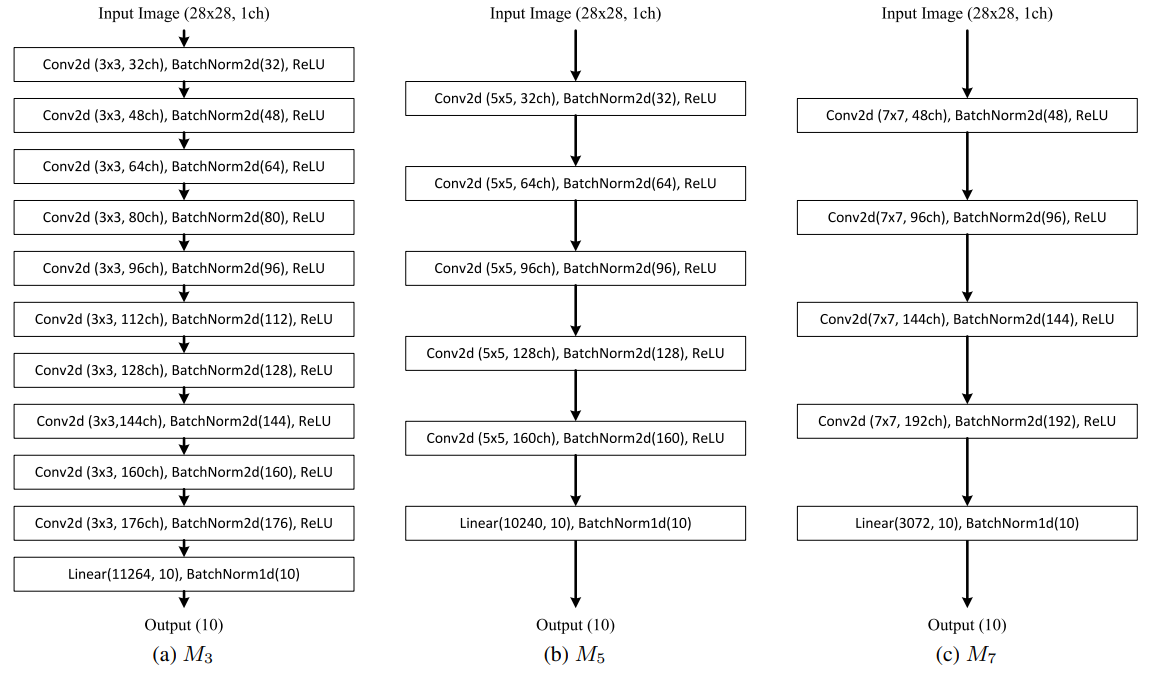

In [ ]:
# M3 definition and summary
def build_M3(input_shape):

  model = Sequential()
  for i in range (10):
    channels = 16*(i+2)
    if i == 0:
        model.add(Conv2D(filters=channels, kernel_size=(3, 3), padding="valid", input_shape=input_shape))
    else:
        model.add(Conv2D(filters=channels, kernel_size=(3, 3), padding="valid"))

    model.add(BatchNormalization())
    model.add(ReLU())

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model

input_shape = (28, 28, 1)
M3 = build_M3(input_shape)
M3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 48)        13872     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 48)        192       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 24, 24, 48)        0

In [ ]:
# M5 definition and summary
def build_M5(input_shape):

  model = Sequential()
  for i in range (5):
    channels = 32 * (i + 1)
    if i == 0:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid", input_shape=input_shape))
    else:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid"))

    model.add(BatchNormalization())
    model.add(ReLU())

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model

M5 = build_M5(input_shape)
M5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 96)          │         153,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         307,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 160)           │         512,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 160)           │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 8, 8, 160)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         102,410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,129,650 (4.31 MB)

 Trainable params: 1,128,670 (4.31 MB)

 Non-trainable params: 980 (3.83 KB)

In [ ]:
# M5 definition and summary
def build_M7(input_shape):

  model = Sequential()
  for i in range (4):
    channels = 48 * (i + 1)
    if i == 0:
        model.add(Conv2D(filters=channels, kernel_size=(7, 7), padding="valid", input_shape=input_shape))
    else:
        model.add(Conv2D(filters=channels, kernel_size=(7, 7), padding="valid"))

    model.add(BatchNormalization())
    model.add(ReLU())

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model

M7 = build_M7(input_shape)
M7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 22, 22, 48)        2400      
                                                                 
 batch_normalization_17 (Ba  (None, 22, 22, 48)        192       
 tchNormalization)                                               
                                                                 
 re_lu_15 (ReLU)             (None, 22, 22, 48)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 96)        225888    
                                                                 
 batch_normalization_18 (Ba  (None, 16, 16, 96)        384       
 tchNormalization)                                               
                                                                 
 re_lu_16 (ReLU)             (None, 16, 16, 96)       

From this 3 models, we will take M5 as our benschmark for experiments 1 to 3, M3 and M7 will be used in the ensemble experiments (experiments 4 to 6).

### Experiment 1: Impact of different architectures to performance on MNIST dataset

On this experiment we will compare 4 different architectures, to see how including maxpooling, more dense layers or more conv layers impacts performance. The models we are going to test are the following:
- C1, 2 Conv layers including batch normalization, ReLU and Maxpooling between every pair of layers and a final dense layer.
- C2, C1 + an aditional dense layer at the end.
- C3, C1 with maxpooling every 2 conv layers, so we will have 4 conv layers instead of 2.
- M5.

On each and every one of the new architectures, we are using padding to keep the size of the image the same between layers. This is because we are already reducing the feature size with pooling, so there is no need to further reduce it.

Every model has a kernel size of 5x5. A diagram showing the specific architecture of each model (except M5) is included in this image:

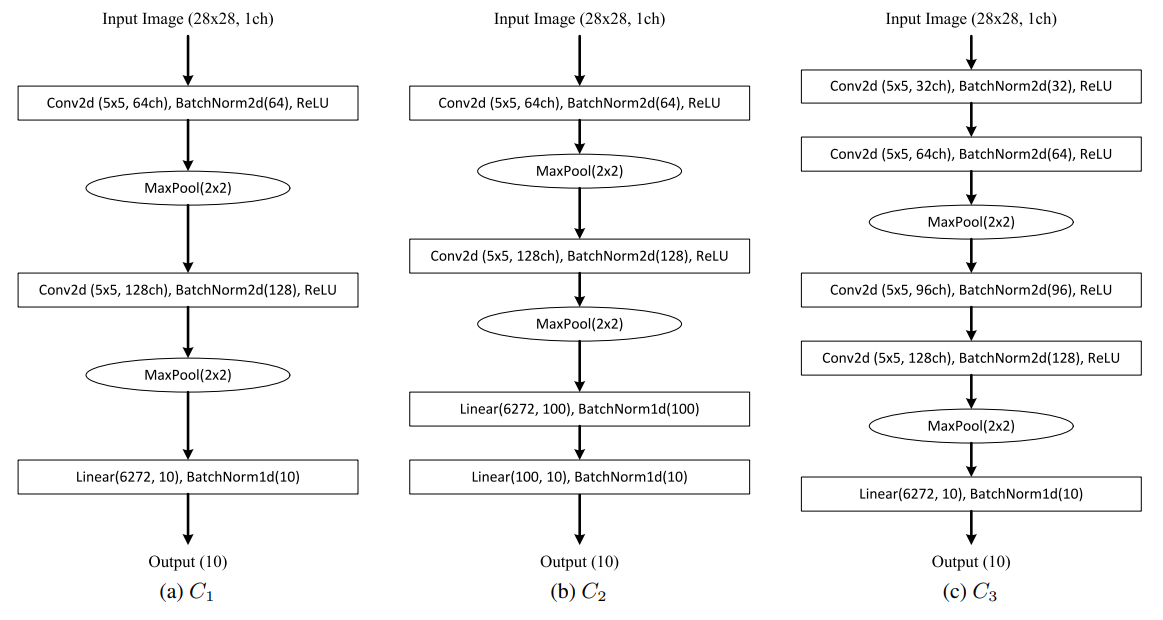

In [ ]:
def build_C1(input_shape):
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model


C1 = build_C1(input_shape)
C1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_22 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_19 (ReLU)             (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_23 (Ba  (None, 14, 14, 128)      

In [ ]:
def build_C2(input_shape):
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model

C2 = build_C2(input_shape)
C2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_25 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_21 (ReLU)             (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_26 (Ba  (None, 14, 14, 128)      

In [ ]:
def build_C3(input_shape):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="same", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=96, kernel_size=(5, 5), padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model

C3 = build_C3(input_shape)
C3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_29 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 re_lu_24 (ReLU)             (None, 28, 28, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        51264     
                                                                 
 batch_normalization_30 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_25 (ReLU)             (None, 28, 28, 64)       

In [ ]:
# Early stopping definition, will be used in every experiment
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate decay callback will also be used in every experiment
initial_learning_rate = 0.001
decay_rate = 0.98

def lr_schedule(epoch):
    return initial_learning_rate * (decay_rate ** epoch)

lr_callback = LearningRateScheduler(lr_schedule)

# Adam optimizer will also be used in every experiment
optimizer = Adam(learning_rate=initial_learning_rate)

In [ ]:
# Initialize lists to store accuracy and history
C1_accuracies = []
C1_histories = []

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    C1 = build_C1(input_shape)
    C1.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    C1_history = C1.fit(
        X_train, y_train,
        epochs=150,
        batch_size=120,
        verbose=0,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    C1_histories.append(C1_history.history)

    # Predict on the test set
    y_pred = C1.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    C1_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
C1_average_accuracy = np.mean(C1_accuracies)
print(f'Average test accuracy over 10 iterations: {C1_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C1_accuracies.npy', C1_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C1_histories.npy', C1_histories)

Starting iteration 1
Restoring model weights from the end of the best epoch: 28.
Epoch 38: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 1: 99.41%
Starting iteration 2
Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 2: 99.29%
Starting iteration 3
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 3: 99.30%
Starting iteration 4
Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 4: 99.34%
Starting iteration 5
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 5: 99.14%
Start

In [ ]:
# Initialize lists to store accuracy and history
C2_accuracies = []
C2_histories = []

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    C2 = build_C2(input_shape)
    C2.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    C2_history = C2.fit(
        X_train, y_train,
        epochs=150,
        batch_size=120,
        verbose=0,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    C2_histories.append(C2_history.history)

    # Predict on the test set
    y_pred = C2.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    C2_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
C2_average_accuracy = np.mean(C2_accuracies)
print(f'Average test accuracy over 10 iterations: {C2_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C2_accuracies.npy', C2_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C2_histories.npy', C2_histories)

Starting iteration 1
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 1: 99.45%
Starting iteration 2
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 2: 99.49%
Starting iteration 3
Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 3: 99.50%
Starting iteration 4
Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping
313/313 [==============================] - 1s 2ms/step
Test accuracy for iteration 4: 99.48%
Starting iteration 5
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 5: 99.47%
Start

In [ ]:
# Initialize lists to store accuracy and history
C3_accuracies = []
C3_histories = []

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    C3 = build_C3(input_shape)
    C3.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    C3_history = C3.fit(
        X_train, y_train,
        epochs=150,
        batch_size=120,
        verbose=0,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    C3_histories.append(C3_history.history)

    # Predict on the test set
    y_pred = C3.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    C3_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
C3_average_accuracy = np.mean(C3_accuracies)
print(f'Average test accuracy over 10 iterations: {C3_average_accuracy * 100:.2f}%')


# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C3_accuracies.npy', C3_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C3_histories.npy', C3_histories)

Starting iteration 1
Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 1: 99.61%
Starting iteration 2
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 2: 99.65%
Starting iteration 3
Restoring model weights from the end of the best epoch: 28.
Epoch 38: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 3: 99.58%
Starting iteration 4
Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 4: 99.60%
Starting iteration 5
Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy for iteration 5: 99.62%
Start

In [ ]:
# Initialize lists to store accuracy and history
M5_accuracies = []
M5_histories = []

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5 = build_M5(input_shape)
    M5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_history = M5.fit(
        X_train, y_train,
        epochs=150,
        batch_size=120,
        verbose=0,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    M5_histories.append(M5_history.history)

    # Predict on the test set
    y_pred = M5.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    M5_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
M5_average_accuracy = np.mean(M5_accuracies)
print(f'Average test accuracy over 10 iterations: {M5_average_accuracy * 100:.2f}%')


# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_accuracies.npy', M5_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_histories.npy', M5_histories)

Starting iteration 1


KeyboardInterrupt: 

In [ ]:
# Build and compile model
M5 = build_M5(input_shape)
M5.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
M5_history = M5.fit(
    X_train, y_train,
    epochs=150,
    batch_size=120,
    verbose=0,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, lr_callback]
)

# Store history
history = M5_history.history

# Predict on the test set
y_pred = M5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_accuracy_10.npy', test_accuracy)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_history_10.npy', history)

Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy: 99.53%


#### Result summary

In [ ]:
def pad_history(history, max_length):
    for key in history.keys():
        padding = [np.nan] * (max_length - len(history[key]))
        history[key] = np.concatenate([history[key], padding])
    return history

def calculate_avg_history(history_arr):
  # Find the maximum number of epochs
  max_epochs = max([len(hist['loss']) for hist in history_arr])

  # Pad all histories
  padded_histories = [pad_history(hist, max_epochs) for hist in history_arr]

  # Calculate the average history
  avg_history = {key: np.nanmean([hist[key] for hist in padded_histories], axis=0) for key in padded_histories[0]}
  return avg_history

In [ ]:
C1_histories = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C1_histories.npy', allow_pickle=True)
C1_avg_history = calculate_avg_history(C1_histories)
# print(C1_histories)

C1_accuracies = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C1_accuracies.npy', allow_pickle=True)

print(C1_accuracies)


C2_histories = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C2_histories.npy', allow_pickle=True)
C2_avg_history = calculate_avg_history(C2_histories)
# print(C2_histories)

C2_accuracies = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C2_accuracies.npy', allow_pickle=True)

print(C2_accuracies)



C3_histories = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C3_histories.npy', allow_pickle=True)
C3_avg_history = calculate_avg_history(C3_histories)
# print(C3_histories)

C3_accuracies = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/C3_accuracies.npy', allow_pickle=True)

print(C3_accuracies)

M5_histories = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_histories.npy', allow_pickle=True)
M5_avg_history = calculate_avg_history(M5_histories)
# print(M5_histories)

M5_accuracies = []
for i in range(10):
  accuracy = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_1/M5_accuracy_' + str(i + 1) + '.npy', allow_pickle=True)
  M5_accuracies.append(accuracy)

M5_accuracies = np.array(M5_accuracies)

print(M5_accuracies)

[0.9941 0.9929 0.993  0.9934 0.9914 0.9933 0.9943 0.994  0.9946 0.9938]
[0.9945 0.9949 0.995  0.9948 0.9947 0.9944 0.994  0.9947 0.9942 0.9948]
[0.9961 0.9965 0.9958 0.996  0.9962 0.9963 0.9961 0.9963 0.9957 0.9953]
[0.9958 0.9962 0.9955 0.9957 0.996  0.9959 0.996  0.9964 0.9961 0.9953]


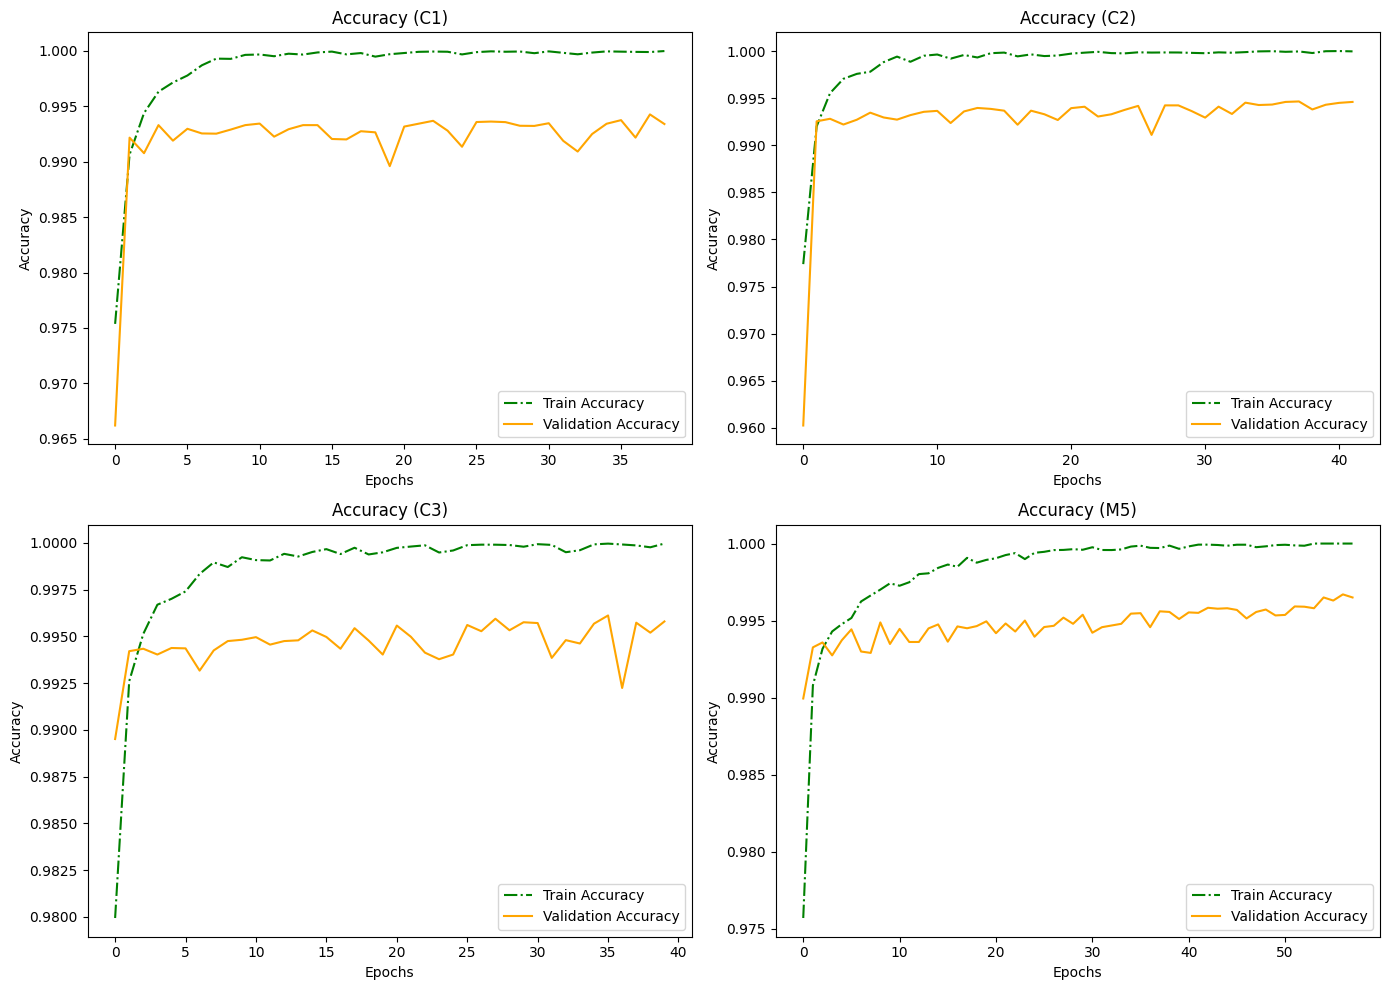

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for C1
axs[0, 0].plot(C1_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
axs[0, 0].plot(C1_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
axs[0, 0].set_title('Accuracy (C1)')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot for C2
axs[0, 1].plot(C2_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
axs[0, 1].plot(C2_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
axs[0, 1].set_title('Accuracy (C2)')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot for C3
axs[1, 0].plot(C3_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
axs[1, 0].plot(C3_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
axs[1, 0].set_title('Accuracy (C3)')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Plot for M5
axs[1, 1].plot(M5_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
axs[1, 1].plot(M5_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
axs[1, 1].set_title('Accuracy (M5)')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

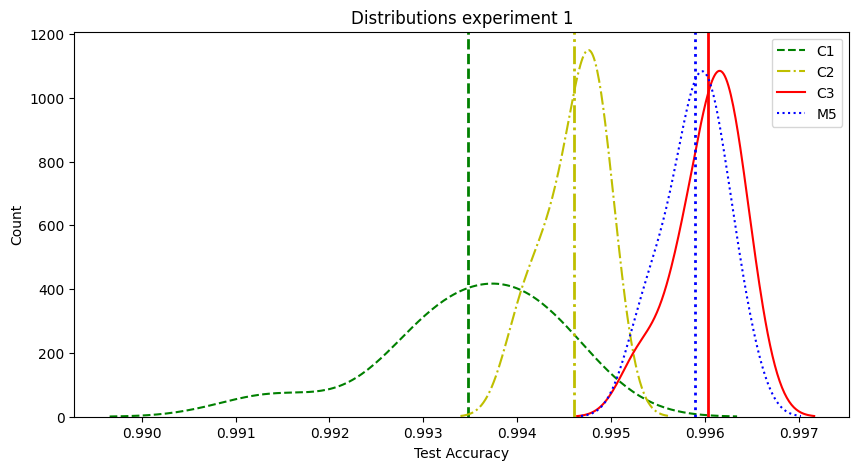

In [ ]:
from matplotlib.ticker import PercentFormatter


# Set up the figure
plt.figure(figsize=(10, 5))

# Plot KDE for the dataset
sns.kdeplot(C1_accuracies, label="C1", linestyle='--', color='g')
plt.axvline(np.mean(C1_accuracies), color='g', linestyle='--', linewidth=2)

sns.kdeplot(C2_accuracies, label="C2", linestyle='-.', color='y')
plt.axvline(np.mean(C2_accuracies), color='y', linestyle='-.', linewidth=2)

sns.kdeplot(C3_accuracies, label="C3", linestyle='-', color='r')
plt.axvline(np.mean(C3_accuracies), color='r', linestyle='-', linewidth=2)

sns.kdeplot(M5_accuracies, label="M5", linestyle=':', color='b')
plt.axvline(np.mean(M5_accuracies), color='b', linestyle=':', linewidth=2)

# Set titles and labels
plt.title("Distributions experiment 1")
plt.xlabel('Test Accuracy')
plt.ylabel('Count')

# Add legend
plt.legend()


# Display the plot
plt.show()

In [ ]:
# Calculate margin of error and mean accuracy for each model
exp1_data = {
    "Model": ["C1", "C2", "C3", "M5"],
    "Mean Accuracy": [
        np.mean(C1_accuracies),
        np.mean(C2_accuracies),
        np.mean(C3_accuracies),
        np.mean(M5_accuracies),
    ],
    "Margin of Error": [
        calculate_margin_of_error(C1_accuracies),
        calculate_margin_of_error(C2_accuracies),
        calculate_margin_of_error(C3_accuracies),
        calculate_margin_of_error(M5_accuracies),
    ],
}

# Create a DataFrame
df = pd.DataFrame(exp1_data)

# Format the output to include the margin of error
df["Test Accuracy"] = df["Mean Accuracy"].map(lambda x: f"{x:.4f}") + " ± " + df["Margin of Error"].map(lambda x: f"{x:.4f}")

# Select and reorder columns
df = df[["Model", "Test Accuracy"]]

# Display the table
print(df)

  Model    Test Accuracy
0    C1  0.9935 ± 0.0007
1    C2  0.9946 ± 0.0002
2    C3  0.9960 ± 0.0003
3    M5  0.9959 ± 0.0002


### Experiment 2: Impact of data augmentation

On this experiment we will compare 4 different aproaches to data augmentation to study its effects, we will use M5 as our model for simplicity and to keep it as the "base" model. The 4 different aproaches will be:
- No data augmentation.
- 20% random translation on each direction.
- 20 degree random rotation.
- Both translation and rotation.

In [ ]:
# Create the ImageDataGenerator with rotation and translation
datagen_traslation = ImageDataGenerator(
    width_shift_range=0.2,  # translate images horizontally by 20% of the width
    height_shift_range=0.2  # translate images vertically by 20% of the height
)

datagen_rotation = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 20)
)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [ ]:
# Fit the generator to your training data
datagen.fit(X_train)

X_subset = X_train[:1]
y_subset = y_train[:1]

augmented_images = []
augmented_labels = []

for _ in range(10):
    x_batch, y_batch = next(datagen.flow(X_subset, y_subset, batch_size=9))
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)

# Convert lists to arrays for easier handling
augmented_images = np.vstack(augmented_images)
augmented_labels = np.vstack(augmented_labels)

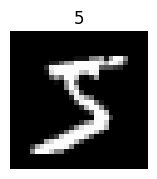

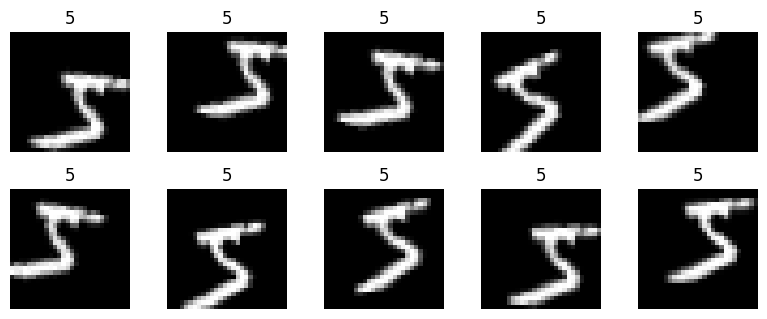

In [ ]:
def show_images(x, y, num_images=100):
    num_filas = num_columnas = 5
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap='gray')
        plt.title(f'{y[i].argmax()}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con el conjunto de entrenamiento
show_images(X_train, y_train, num_images=1)
show_images(augmented_images, augmented_labels, num_images=10)

In [ ]:
# Initialize lists to store accuracy and history
traslation_accuracies = []
traslation_histories = []

datagen_traslation.fit(X_train)

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5 = build_M5(input_shape)
    M5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_history = M5.fit(
        datagen_traslation.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    traslation_histories.append(M5_history.history)

    # Predict on the test set
    y_pred = M5.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    traslation_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
traslation_average_accuracy = np.mean(traslation_accuracies)
print(f'Average test accuracy over 10 iterations: {traslation_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/traslation_accuracies.npy', traslation_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/traslation_histories.npy', traslation_histories)

In [ ]:
# Initialize lists to store accuracy and history
rotation_accuracies = []
rotation_histories = []

datagen_rotation.fit(X_train)

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5 = build_M5(input_shape)
    M5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_history = M5.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    rotation_histories.append(M5_history.history)

    # Predict on the test set
    y_pred = M5.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    rotation_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
rotation_average_accuracy = np.mean(rotation_accuracies)
print(f'Average test accuracy over 10 iterations: {rotation_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/rotation_accuracies.npy', rotation_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/rotation_histories.npy', rotation_histories)

In [ ]:
datagen.fit(X_train)

# Build and compile model
M5 = build_M5(input_shape)
M5.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
# M5_history = M5.fit(
#     X_train, y_train,
#     epochs=150,
#     batch_size=120,
#     verbose=0,
#     validation_data=(X_test, y_test),
#     shuffle=True,
#     callbacks=[early_stopping, lr_callback]
# )
M5_history = M5.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

# Store history
history = M5_history.history

# Predict on the test set
y_pred = M5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')


# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/tr_accuracy_1.npy', test_accuracy)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/tr_history_1.npy', history)

Restoring model weights from the end of the best epoch: 122.
Epoch 132: early stopping
313/313 [==============================] - 1s 3ms/step
Test accuracy: 99.65%


In [ ]:
# Initialize lists to store accuracy and history
tr_accuracies = []
tr_histories = []

datagen.fit(X_train)

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5 = build_M5(input_shape)
    M5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_history = M5.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    tr_histories.append(M5_history.history)

    # Predict on the test set
    y_pred = M5.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    tr_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
tr_average_accuracy = np.mean(tr_accuracies)
print(f'Average test accuracy over 10 iterations: {tr_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/tr_accuracies.npy', tr_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/tr_histories.npy', tr_histories)

#### Result summary

In [ ]:
translation_histories = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/translation_histories.npy', allow_pickle=True)
translation_avg_history = calculate_avg_history(translation_histories)
# print(M5_histories)

translation_accuracies = []
for i in range(10):
  accuracy = np.load('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_2/translation_accuracy_' + str(i + 1) + '.npy', allow_pickle=True)
  translation_accuracies.append(accuracy)

translation_accuracies = np.array(translation_accuracies)

print(translation_accuracies)

[0.9952 0.9946 0.9959 0.9958 0.9956 0.9963 0.9964 0.996  0.9962 0.9958]


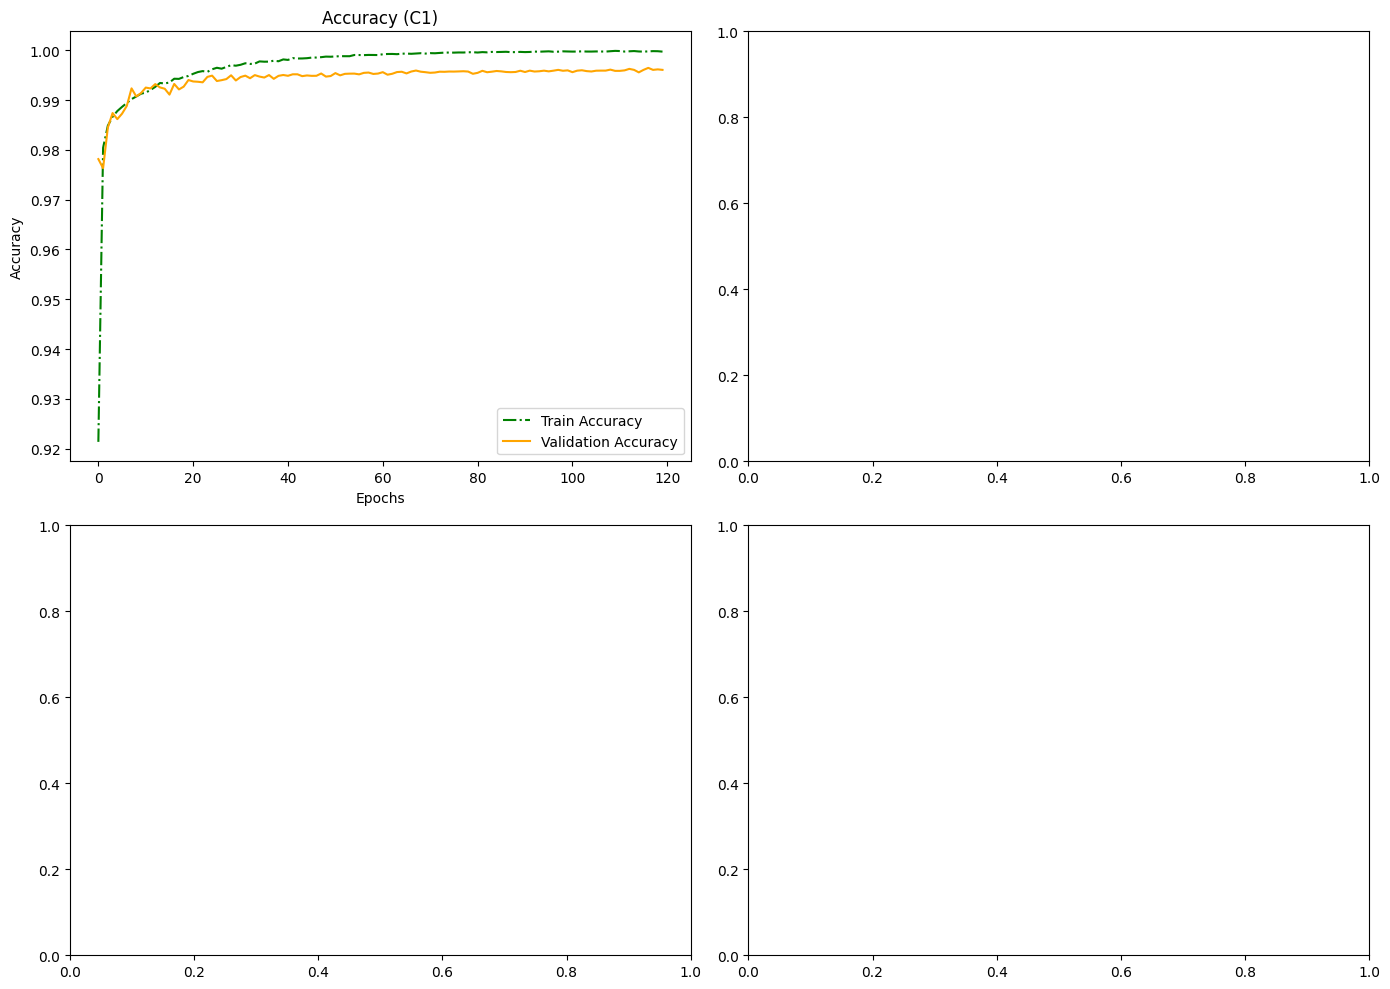

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for translation
axs[0, 0].plot(translation_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
axs[0, 0].plot(translation_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
axs[0, 0].set_title('Accuracy (C1)')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# # Plot for C2
# axs[0, 1].plot(C2_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
# axs[0, 1].plot(C2_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
# axs[0, 1].set_title('Accuracy (C2)')
# axs[0, 1].set_xlabel('Epochs')
# axs[0, 1].set_ylabel('Accuracy')
# axs[0, 1].legend()

# # Plot for C3
# axs[1, 0].plot(C3_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
# axs[1, 0].plot(C3_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
# axs[1, 0].set_title('Accuracy (C3)')
# axs[1, 0].set_xlabel('Epochs')
# axs[1, 0].set_ylabel('Accuracy')
# axs[1, 0].legend()

# # Plot for M5
# axs[1, 1].plot(M5_avg_history['accuracy'], label='Train Accuracy', linestyle='-.', color='green')
# axs[1, 1].plot(M5_avg_history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='orange')
# axs[1, 1].set_title('Accuracy (M5)')
# axs[1, 1].set_xlabel('Epochs')
# axs[1, 1].set_ylabel('Accuracy')
# axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

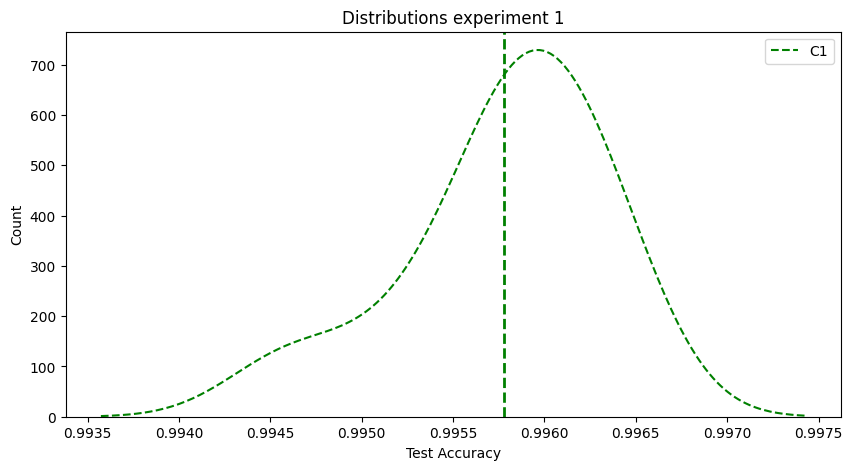

In [ ]:
from matplotlib.ticker import PercentFormatter


# Set up the figure
plt.figure(figsize=(10, 5))

# Plot KDE for the dataset
sns.kdeplot(translation_accuracies, label="C1", linestyle='--', color='g')
plt.axvline(np.mean(translation_accuracies), color='g', linestyle='--', linewidth=2)

# sns.kdeplot(C2_accuracies, label="C2", linestyle='-.', color='y')
# plt.axvline(np.mean(C2_accuracies), color='y', linestyle='-.', linewidth=2)

# sns.kdeplot(C3_accuracies, label="C3", linestyle='-', color='r')
# plt.axvline(np.mean(C3_accuracies), color='r', linestyle='-', linewidth=2)

# sns.kdeplot(M5_accuracies, label="M5", linestyle=':', color='b')
# plt.axvline(np.mean(M5_accuracies), color='b', linestyle=':', linewidth=2)

# Set titles and labels
plt.title("Distributions experiment 1")
plt.xlabel('Test Accuracy')
plt.ylabel('Count')

# Add legend
plt.legend()


# Display the plot
plt.show()

In [ ]:
# Calculate margin of error and mean accuracy for each model
exp1_data = {
    "Model": ["C1", "C2", "C3", "M5"],
    "Mean Accuracy": [
        np.mean(C1_accuracies),
        np.mean(C2_accuracies),
        np.mean(C3_accuracies),
        np.mean(M5_accuracies),
    ],
    "Margin of Error": [
        calculate_margin_of_error(C1_accuracies),
        calculate_margin_of_error(C2_accuracies),
        calculate_margin_of_error(C3_accuracies),
        calculate_margin_of_error(M5_accuracies),
    ],
}

# Create a DataFrame
df = pd.DataFrame(exp1_data)

# Format the output to include the margin of error
df["Test Accuracy"] = df["Mean Accuracy"].map(lambda x: f"{x:.4f}") + " ± " + df["Margin of Error"].map(lambda x: f"{x:.4f}")

# Select and reorder columns
df = df[["Model", "Test Accuracy"]]

# Display the table
print(df)

  Model    Test Accuracy
0    C1  0.9935 ± 0.0007
1    C2  0.9946 ± 0.0002
2    C3  0.9960 ± 0.0003
3    M5  0.9959 ± 0.0002


### Experiment 3: Impact of batch normalization

Similar to the 2 previous experiments on this one we will compare 3 different aproaches, to see how batch normalization impacts performance. The architectures used will be modified versions of M5.
- M5 without batch normalization.
- M5 with batch normalization only at the final layer.
- M5 (batch normalization at every layer).

In [ ]:
# M3 definition and summary
def build_M5_no_BN(input_shape):

  model = Sequential()
  for i in range (5):
    channels = 32 * (i + 1)
    if i == 0:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid", input_shape=input_shape))
    else:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid"))

    model.add(ReLU())

  model.add(Flatten())
  model.add(Dense(10))
  model.add(Softmax())
  return model
# M3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

M5_no_BN = build_M5_no_BN(input_shape)
M5_no_BN.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 re_lu_70 (ReLU)             (None, 24, 24, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 re_lu_71 (ReLU)             (None, 20, 20, 64)        0         
                                                                 
 conv2d_69 (Conv2D)          (None, 16, 16, 96)        153696    
                                                                 
 re_lu_72 (ReLU)             (None, 16, 16, 96)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 12, 12, 128)     

In [ ]:
# M3 definition and summary
def build_M5_last_BN(input_shape):

  model = Sequential()
  for i in range (5):
    channels = 32 * (i + 1)
    if i == 0:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid", input_shape=input_shape))
    else:
        model.add(Conv2D(filters=channels, kernel_size=(5, 5), padding="valid"))

    model.add(ReLU())

  model.add(Flatten())
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Softmax())
  return model
# M3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

M5_last_BN = build_M5_last_BN(input_shape)
M5_last_BN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 re_lu_65 (ReLU)             (None, 24, 24, 32)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 re_lu_66 (ReLU)             (None, 20, 20, 64)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 16, 16, 96)        153696    
                                                                 
 re_lu_67 (ReLU)             (None, 16, 16, 96)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 12, 12, 128)     

In [ ]:
# Initialize lists to store accuracy and history
no_BN_accuracies = []
no_BN_histories = []

datagen.fit(X_train)

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5_no_BN = build_M5_no_BN(input_shape)
    M5_no_BN.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_no_BN_history = M5_no_BN.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    no_BN_histories.append(M5_no_BN_history.history)

    # Predict on the test set
    y_pred = M5_no_BN.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    no_BN_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
no_BN_average_accuracy = np.mean(no_BN_accuracies)
print(f'Average test accuracy over 10 iterations: {no_BN_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_3/no_BN_accuracies.npy', no_BN_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_3/no_BN_histories.npy', no_BN_histories)

In [ ]:
no_BN_avg_history = calculate_avg_history(no_BN_histories)

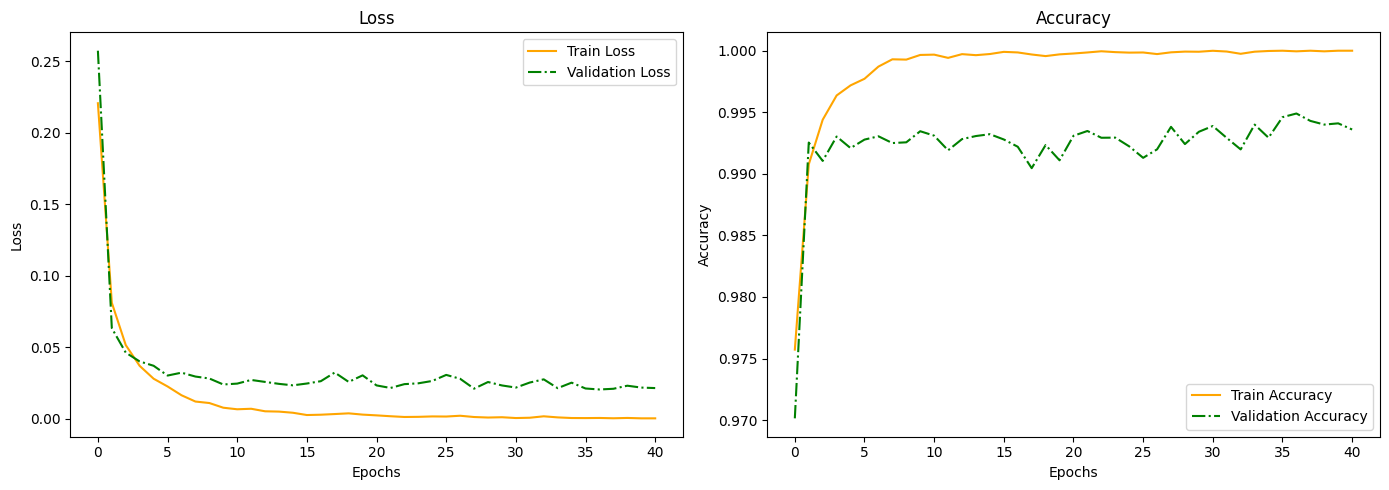

In [ ]:
show_history(no_BN_avg_history)

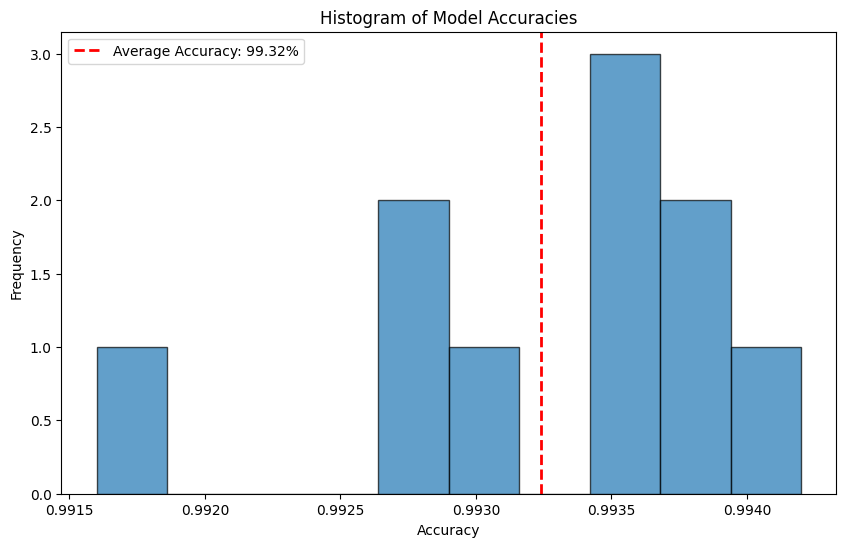

In [ ]:
plot_histograms(no_BN_accuracies, no_BN_average_accuracy)

In [ ]:
# Initialize lists to store accuracy and history
last_BN_accuracies = []
last_BN_histories = []

datagen.fit(X_train)

for i in range(10):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5_last_BN = build_M5_last_BN(input_shape)
    M5_last_BN.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_last_BN_history = M5_last_BN.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    last_BN_histories.append(M5_last_BN_history.history)

    # Predict on the test set
    y_pred = M5_last_BN.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    last_BN_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
last_BN_average_accuracy = np.mean(last_BN_accuracies)
print(f'Average test accuracy over 10 iterations: {last_BN_average_accuracy * 100:.2f}%')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_3/last_BN_accuracies.npy', last_BN_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_3/last_BN_histories.npy', last_BN_histories)

In [ ]:
last_BN_avg_history = calculate_avg_history(last_BN_histories)

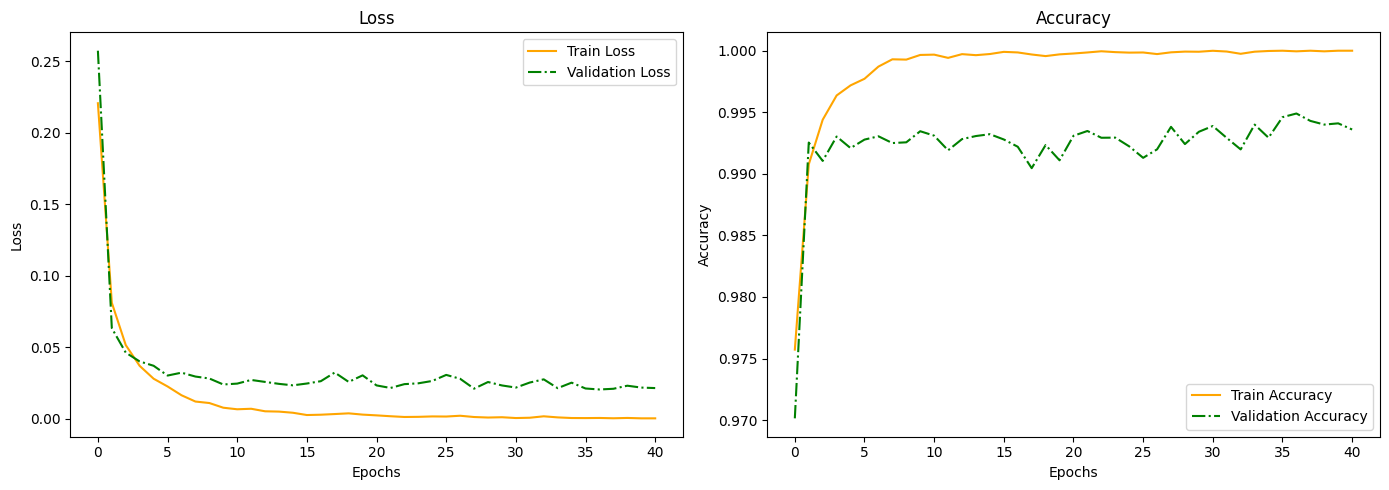

In [ ]:
show_history(last_BN_avg_history)

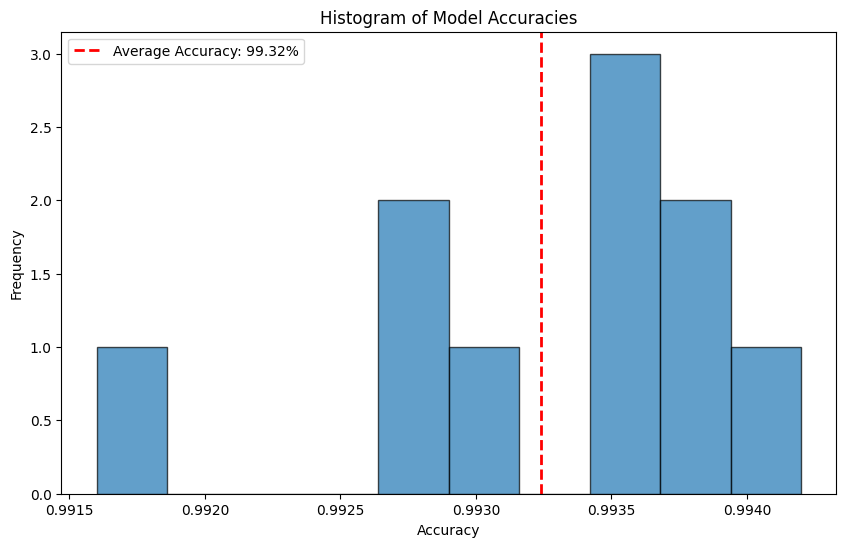

In [ ]:
plot_histograms(last_BN_accuracies, last_BN_average_accuracy)

### Experiment 4: Training the base models

This next 3 experiments will be focused on building ensembles to improve the performance obtained by base models. As we said the base models that are going to be used to compare and build the different ensembles will be M3, M5 and M7.

We train 30 different M3, M5 and M7 to obtain the average accuracy. Different to previous experiments, the models will be stored for later use and thus save time on training building the ensembles. This will also be used on experiment 6.

In [ ]:
# Initialize lists to store accuracy and history
M3_accuracies = []
M3_histories = []
M3_models = []

#datagen is fitted to help schedule later training of the modules,
#otherwise we could run into redundant execution of different cells
datagen.fit(X_train)

for i in range(30):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M3 = build_M3(input_shape)
    M3.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M3_history = M3.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    M3_histories.append(M3_history.history)
    M3_models.append(M3)

    # Predict on the test set
    y_pred = M3.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    M3_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
M3_average_accuracy = np.mean(M3_accuracies)
print(f'Average test accuracy over 10 iterations: {M3_average_accuracy * 100:.2f}%')

# Save the models to drive so no retraining is needed
for i, model in enumerate(M3_models):
    model.save(f'/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/models/M3/M3_model_{i}.h5')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M3_accuracies.npy', M3_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M3_histories.npy', M3_histories)

In [ ]:
# Initialize lists to store accuracy and history
M5_accuracies = []
M5_histories = []
M5_models = []

#datagen is fitted to help schedule later training of the modules,
#otherwise we could run into redundant execution of different cells
datagen.fit(X_train)

for i in range(30):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M5 = build_M5(input_shape)
    M5.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M5_history = M5.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    M5_histories.append(M5_history.history)
    M5_models.append(M5)

    # Predict on the test set
    y_pred = M5.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    M5_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
M5_average_accuracy = np.mean(M5_accuracies)
print(f'Average test accuracy over 10 iterations: {M5_average_accuracy * 100:.2f}%')

# Save the models to drive so no retraining is needed
for i, model in enumerate(M5_models):
    model.save(f'/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/models/M5/M5_model_{i}.h5')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M5_accuracies.npy', M5_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M5_histories.npy', M5_histories)

In [ ]:
# Initialize lists to store accuracy and history
M7_accuracies = []
M7_histories = []
M7_models = []

#datagen is fitted to help schedule later training of the modules,
#otherwise we could run into redundant execution of different cells
datagen.fit(X_train)

for i in range(30):
    print(f"Starting iteration {i+1}")

    # Build and compile model
    M7 = build_M7(input_shape)
    M7.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    M7_history = M7.fit(
        datagen.flow(X_train, y_train, batch_size=120),
        epochs=150,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_callback]
    )

    # Store history
    M7_histories.append(M7_history.history)
    M7_models.append(M7)

    # Predict on the test set
    y_pred = M7.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
    M7_accuracies.append(test_accuracy)

    print(f'Test accuracy for iteration {i+1}: {test_accuracy * 100:.2f}%')

# Calculate average accuracy
M7_average_accuracy = np.mean(M7_accuracies)
print(f'Average test accuracy over 10 iterations: {M7_average_accuracy * 100:.2f}%')

# Save the models to drive so no retraining is needed
for i, model in enumerate(M7_models):
    model.save(f'/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/models/M7/M7_model_{i}.h5')

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M7_accuracies.npy', M7_accuracies)
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_4/M7_histories.npy', M7_histories)

In [ ]:
M3_avg_history = calculate_avg_history(M3_histories)
M5_avg_history = calculate_avg_history(M5_histories)
M7_avg_history = calculate_avg_history(M7_histories)

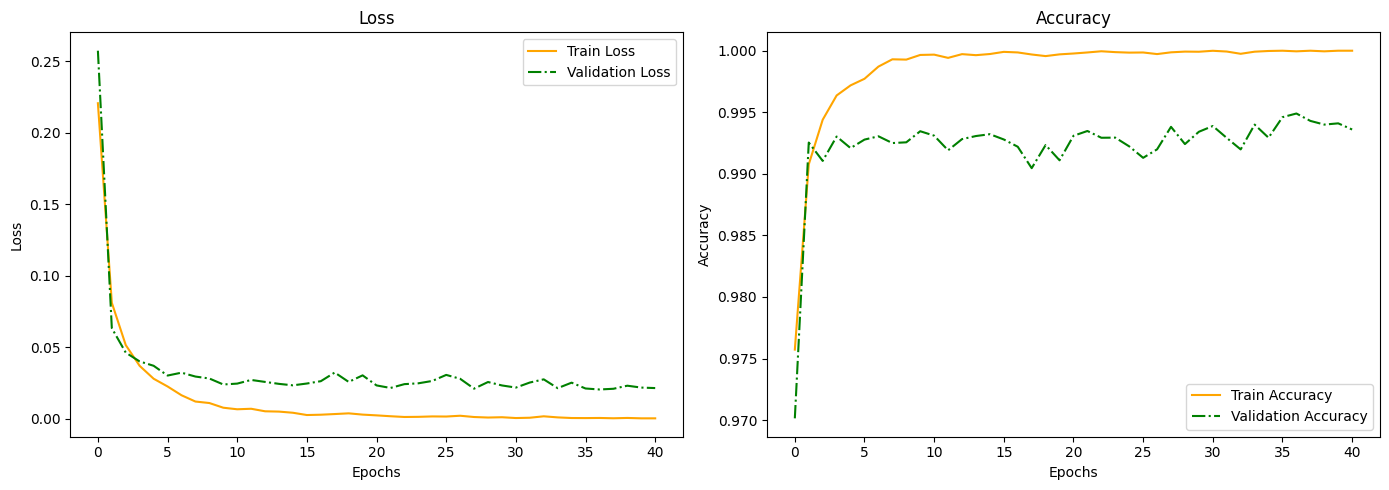

In [ ]:
show_history(M3_avg_history)
show_history(M5_avg_history)
show_history(M7_avg_history)

In [ ]:
plot_histograms(M3_accuracies, M3_average_accuracy, bins=30)
plot_histograms(M5_accuracies, M5_average_accuracy, bins=30)
plot_histograms(M7_accuracies, M7_average_accuracy, bins=30)

### Experiment 5: Impact of batch normalization

We now define 4 different ensemble aproches to improve performance over the base models. This aproaches are as follow
- 3 homogeneous ensembles with the architecture Mk + Mk + Mk with k in {3, 5, 7}.
- 1 heterogeneous ensemble with the architecture M3 + M5 + M7.

The models used to build the ensembles will be randomly selected from the trained models in the previous experiment. This will be done 100 times, to have a better grasp at the true values this approaches can get.

All aproaches will use a majority voting sistem to calculate the output, where if 2 or more models choose a class, that class will be chosen. Other wise, if all 3 disagree, a random of the 3 outputs will be selected.

As contestors to this ensembles, the best models out of the previous experiment will be selected. This makes for an "unfair" comparison, as we have 30 trained models from the previous experiment but 100 different combinations of ensembles. This is due to lack of resources, as training 100 models of each M3, M5 and M7 would take way too long in the google drive base GPUs. Also, this experiments are a recreation of an original paper, done for academic purpouses, training 10, 100 or 1000 models will not change the modus operandi.

In [ ]:
def majority_vote(predictions):
    # Transpose to iterate over samples instead of predictions for each model
    predictions = predictions.T
    final_predictions = np.zeros(predictions.shape[0], dtype=int)

    for i, sample_predictions in enumerate(predictions):
        unique, counts = np.unique(sample_predictions, return_counts=True)
        max_count = np.max(counts)
        max_count_indices = np.where(counts == max_count)[0]

        if len(max_count_indices) > 1:  # If there is a tie
            chosen_index = np.random.choice(max_count_indices)
            final_predictions[i] = unique[chosen_index]
        else:
            final_predictions[i] = unique[max_count_indices[0]]

    return final_predictions

In [ ]:
#Homogeneous M3 ensemble testing
M3_homo_accuracies = []

for i in range(100):
    M3_random_indices = random.sample(range(30), 3)
    M3_selected_models = [M3_models[i] for i in M3_random_indices]

    # Initialize an array to store predictions
    predictions = np.zeros((len(X_test), len(M3_selected_models)))

    # Get predictions from each selected model
    for i, model in enumerate(M3_selected_models):
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        predictions[:, i] = y_pred_classes
        # Predict on the test set

    # Apply majority voting
    # final_predictions, _ = mode(predictions, axis=1)
    # final_predictions = final_predictions.ravel()
    final_predictions = majority_vote(predictions)
    y_test_classes = np.argmax(y_test, axis=1)
    ensemble_accuracy = accuracy_score(y_test_classes, final_predictions)
    print(f'Ensemble test accuracy: {ensemble_accuracy * 100:.2f}%')

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, final_predictions)
    M3_homo_accuracies.append(test_accuracy)

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_5/M3_homo_accuracies.npy', M3_homo_accuracies)

In [ ]:
#Homogeneous M5 ensemble testing
M5_homo_accuracies = []

for i in range(100):
    M5_random_indices = random.sample(range(30), 3)
    M5_selected_models = [M5_models[i] for i in M5_random_indices]

    # Initialize an array to store predictions
    predictions = np.zeros((len(X_test), len(M5_selected_models)))

    # Get predictions from each selected model
    for i, model in enumerate(M5_selected_models):
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        predictions[:, i] = y_pred_classes
        # Predict on the test set

    # Apply majority voting
    # final_predictions, _ = mode(predictions, axis=1)
    # final_predictions = final_predictions.ravel()
    final_predictions = majority_vote(predictions)
    y_test_classes = np.argmax(y_test, axis=1)
    ensemble_accuracy = accuracy_score(y_test_classes, final_predictions)
    print(f'Ensemble test accuracy: {ensemble_accuracy * 100:.2f}%')

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, final_predictions)
    M5_homo_accuracies.append(test_accuracy)

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_5/M5_homo_accuracies.npy', M5_homo_accuracies)

In [ ]:
#Homogeneous M7 ensemble testing
M7_homo_accuracies = []

for i in range(100):
    M7_random_indices = random.sample(range(30), 3)
    M7_selected_models = [M7_models[i] for i in M7_random_indices]

    # Initialize an array to store predictions
    predictions = np.zeros((len(X_test), len(M7_selected_models)))

    # Get predictions from each selected model
    for i, model in enumerate(M7_selected_models):
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        predictions[:, i] = y_pred_classes
        # Predict on the test set

    # Apply majority voting
    # final_predictions, _ = mode(predictions, axis=1)
    # final_predictions = final_predictions.ravel()
    final_predictions = majority_vote(predictions)
    y_test_classes = np.argmax(y_test, axis=1)
    ensemble_accuracy = accuracy_score(y_test_classes, final_predictions)
    print(f'Ensemble test accuracy: {ensemble_accuracy * 100:.2f}%')

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, final_predictions)
    M7_homo_accuracies.append(test_accuracy)

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_5/M7_homo_accuracies.npy', M7_homo_accuracies)

In [ ]:
#Homogeneous M7 ensemble testing
hetero_accuracies = []

def majority_vote(predictions):
    final_predictions, _ = mode(predictions, axis=1)
    return final_predictions.ravel()

for i in range(100):
    M3_random_indices = random.sample(range(30), 1)
    M5_random_indices = random.sample(range(30), 1)
    M7_random_indices = random.sample(range(30), 1)

    # Select the elements correspoding to the indexes
    selected_M3 = [M3_models[j] for j in M3_random_indices]
    selected_M5 = [M5_models[j] for j in M5_random_indices]
    selected_M7 = [M7_models[j] for j in M7_random_indices]

    hetero_selected_models= selected_M3 + selected_M5 + selected_M7

    # Initialize an array to store predictions
    predictions = np.zeros((len(X_test), len(hetero_selected_models)))

    # Get predictions from each selected model
    for i, model in enumerate(hetero_selected_models):
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        predictions[:, i] = y_pred_classes
        # Predict on the test set

    # Apply majority voting
    # final_predictions, _ = mode(predictions, axis=1)
    # final_predictions = final_predictions.ravel()
    final_predictions = majority_vote(predictions)
    y_test_classes = np.argmax(y_test, axis=1)
    ensemble_accuracy = accuracy_score(y_test_classes, final_predictions)
    print(f'Ensemble test accuracy: {ensemble_accuracy * 100:.2f}%')

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, final_predictions)
    M7_homo_accuracies.append(test_accuracy)

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_5/hetero_accuracies.npy', hetero_accuracies)

### Experiment 6: Impact of batch normalization

Similar to the previous experiment on this one we will have a look at a different ensemble aproach. The architecture of the ensembles is much bigger, having an ensemble of homogeneous ensembles. The architecture is defined like follows:
- (M3 + M3 + M3) + (M5 + M5 + M5) + (M7 + M7 + M7).

Where majority voting will be used at each "layer" to define the output.

Now only 10 models will be arranged, taking random models from the previous experiments.

In [ ]:
#Homogeneous M7 ensemble testing
final_accuracies = []

for i in range(10):
    M3_random_indices = random.sample(range(30), 3)
    M5_random_indices = random.sample(range(30), 3)
    M7_random_indices = random.sample(range(30), 3)

    # Select the elements correspoding to the indexes
    selected_M3 = [M3_models[j] for j in M3_random_indices]
    selected_M5 = [M5_models[j] for j in M5_random_indices]
    selected_M7 = [M7_models[j] for j in M7_random_indices]

    final_selected_models= selected_M3 + selected_M5 + selected_M7

    # Initialize an array to store predictions
    predictions = np.zeros((len(X_test), len(final_selected_models)))

    # Get predictions from each selected model
    for i, model in enumerate(final_selected_models):
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        predictions[:, i] = y_pred_classes
        # Predict on the test set

    # Split the predictions into the corresponding sub-ensembles
    M3_predictions = predictions[:, :3]
    M5_predictions = predictions[:, 3:6]
    M7_predictions = predictions[:, 6:]

    # Majority vote the intermediate predictions
    M3_final_predictions = majority_vote(M3_predictions)
    M5_final_predictions = majority_vote(M5_predictions)
    M7_final_predictions = majority_vote(M7_predictions)

    # Mahority vote the final predictions of the ensemble of ensembles
    final_predictions = np.vstack([M3_final_predictions, M5_final_predictions, M7_final_predictions]).T
    final_predictions = majority_vote(final_predictions)

    y_test_classes = np.argmax(y_test, axis=1)
    ensemble_accuracy = accuracy_score(y_test_classes, final_predictions)
    print(f'Ensemble test accuracy: {ensemble_accuracy * 100:.2f}%')

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_classes, final_predictions)
    final_accuracies.append(test_accuracy)

# Save accuracies and histories
np.save('/content/drive/MyDrive/Colab Notebooks/Proyectos/Ensemble/results/experiment_6/final_accuracies.npy', final_accuracies)